In [1]:
import os
from os import path
import pandas as pd
import numpy as np
import math
import tqdm as tqdm
# from tqdm import tqdm
import pickle
import logging


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

import torch
from torch.utils.data.dataset import Dataset

from misc.utils import divide_chunks
from dataset.vocab import Vocabulary

logger = logging.getLogger(__name__)
log = logger


class TransactionDataset(Dataset):
    def __init__(self,
                 mlm,
                 user_ids=None,
                 seq_len=10,
                 num_bins=10,
                 cached=True,
                 root="./data/card/",
                 fname="card_trans",
                 vocab_dir="checkpoints",
                 fextension="",
                 nrows=None,
                 flatten=False,
                 stride=5,
                 adap_thres=10 ** 8,
                 return_labels=False,
                 skip_user=False):

        self.root = root
        self.fname = fname
        self.nrows = nrows
        self.fextension = f'_{fextension}' if fextension else ''
        self.cached = cached
        self.user_ids = user_ids
        self.return_labels = return_labels
        self.skip_user = skip_user

        self.mlm = mlm
        self.trans_stride = stride

        self.flatten = flatten

        self.vocab = Vocabulary(adap_thres)
        self.seq_len = seq_len
        self.encoder_fit = {}

        self.trans_table = None
        self.data = []
        self.labels = []
        self.window_label = []

        self.ncols = None
        self.num_bins = num_bins
        self.encode_data()
        self.init_vocab()
        self.prepare_samples()
        self.save_vocab(vocab_dir)

    def __getitem__(self, index):
        if self.flatten:
            return_data = torch.tensor(self.data[index], dtype=torch.long)
        else:
            return_data = torch.tensor(self.data[index], dtype=torch.long).reshape(self.seq_len, -1)

        if self.return_labels:
            return_data = (return_data, torch.tensor(self.labels[index], dtype=torch.long))

        return return_data

    def __len__(self):
        return len(self.data)

    def save_vocab(self, vocab_dir):
        file_name = path.join(vocab_dir, f'vocab{self.fextension}.nb')
        log.info(f"saving vocab at {file_name}")
        self.vocab.save_vocab(file_name)

    @staticmethod
    def label_fit_transform(column, enc_type="label"):
        if enc_type == "label":
            mfit = LabelEncoder()
        else:
            mfit = MinMaxScaler()
        mfit.fit(column)

        return mfit, mfit.transform(column)

    @staticmethod
    def timeEncoder(X):
        X_hm = X['Time'].str.split(':', expand=True)
        d = pd.to_datetime(dict(year=X['Year'], month=X['Month'], day=X['Day'], hour=X_hm[0], minute=X_hm[1])).astype(
            int)
        return pd.DataFrame(d)

    @staticmethod
    def amountEncoder(X):
        amt = X.apply(lambda x: x[1:]).astype(float).apply(lambda amt: max(1, amt)).apply(math.log)
        return pd.DataFrame(amt)

    @staticmethod
    def fraudEncoder(X):
        fraud = (X == 'Yes').astype(int)
        return pd.DataFrame(fraud)

    @staticmethod
    def nanNone(X):
        return X.where(pd.notnull(X), 'None')

    @staticmethod
    def nanZero(X):
        return X.where(pd.notnull(X), 0)

    def _quantization_binning(self, data):
        qtls = np.arange(0.0, 1.0 + 1 / self.num_bins, 1 / self.num_bins)
        bin_edges = np.quantile(data, qtls, axis=0)  # (num_bins + 1, num_features)
        bin_widths = np.diff(bin_edges, axis=0)
        bin_centers = bin_edges[:-1] + bin_widths / 2  # ()
        return bin_edges, bin_centers, bin_widths

    def _quantize(self, inputs, bin_edges):
        quant_inputs = np.zeros(inputs.shape[0])
        for i, x in enumerate(inputs):
            quant_inputs[i] = np.digitize(x, bin_edges)
        quant_inputs = quant_inputs.clip(1, self.num_bins) - 1  # Clip edges
        return quant_inputs

    def user_level_data(self):
        fname = path.join(self.root, f"preprocessed/{self.fname}.user{self.fextension}.pkl")
        trans_data, trans_labels = [], []

        if self.cached and path.isfile(fname):
            log.info(f"loading cached user level data from {fname}")
            cached_data = pickle.load(open(fname, "rb"))
            trans_data = cached_data["trans"]
            trans_labels = cached_data["labels"]
            columns_names = cached_data["columns"]

        else:
            unique_users = self.trans_table["User"].unique()
            columns_names = list(self.trans_table.columns)

            for user in tqdm.tqdm(unique_users):
                user_data = self.trans_table.loc[self.trans_table["User"] == user]
                user_trans, user_labels = [], []
                for idx, row in user_data.iterrows():
                    row = list(row)

                    # assumption that user is first field
                    skip_idx = 1 if self.skip_user else 0

                    user_trans.extend(row[skip_idx:-1])
                    user_labels.append(row[-1])

                trans_data.append(user_trans)
                trans_labels.append(user_labels)

            if self.skip_user:
                columns_names.remove("User")

            with open(fname, 'wb') as cache_file:
                pickle.dump({"trans": trans_data, "labels": trans_labels, "columns": columns_names}, cache_file)

        # convert to str
        return trans_data, trans_labels, columns_names

    def format_trans(self, trans_lst, column_names):
        trans_lst = list(divide_chunks(trans_lst, len(self.vocab.field_keys) - 2))  # 2 to ignore isFraud and SPECIAL
        user_vocab_ids = []

        sep_id = self.vocab.get_id(self.vocab.sep_token, special_token=True)

        for trans in trans_lst:
            vocab_ids = []
            for jdx, field in enumerate(trans):
                vocab_id = self.vocab.get_id(field, column_names[jdx])
                vocab_ids.append(vocab_id)

            # TODO : need to handle ncols when sep is not added
            if self.mlm:  # and self.flatten:  # only add [SEP] for BERT + flatten scenario
                vocab_ids.append(sep_id)

            user_vocab_ids.append(vocab_ids)

        return user_vocab_ids

    def prepare_samples(self):
        log.info("preparing user level data...")
        trans_data, trans_labels, columns_names = self.user_level_data()

        log.info("creating transaction samples with vocab")
        for user_idx in tqdm.tqdm(range(len(trans_data))):
            user_row = trans_data[user_idx]
            user_row_ids = self.format_trans(user_row, columns_names)

            user_labels = trans_labels[user_idx]

            bos_token = self.vocab.get_id(self.vocab.bos_token, special_token=True)  # will be used for GPT2
            eos_token = self.vocab.get_id(self.vocab.eos_token, special_token=True)  # will be used for GPT2
            for jdx in range(0, len(user_row_ids) - self.seq_len + 1, self.trans_stride):
                ids = user_row_ids[jdx:(jdx + self.seq_len)]
                ids = [idx for ids_lst in ids for idx in ids_lst]  # flattening
                if not self.mlm and self.flatten:  # for GPT2, need to add [BOS] and [EOS] tokens
                    ids = [bos_token] + ids + [eos_token]
                self.data.append(ids)

            for jdx in range(0, len(user_labels) - self.seq_len + 1, self.trans_stride):
                ids = user_labels[jdx:(jdx + self.seq_len)]
                self.labels.append(ids)

                fraud = 0
                if len(np.nonzero(ids)[0]) > 0:
                    fraud = 1
                self.window_label.append(fraud)

        assert len(self.data) == len(self.labels)

        '''
            ncols = total fields - 1 (special tokens) - 1 (label)
            if bert:
                ncols += 1 (for sep)
        '''
        self.ncols = len(self.vocab.field_keys) - 2 + (1 if self.mlm else 0)
        log.info(f"ncols: {self.ncols}")
        log.info(f"no of samples {len(self.data)}")

    def get_csv(self, fname):
        data = pd.read_csv(fname, nrows=self.nrows)
        if self.user_ids:
            log.info(f'Filtering data by user ids list: {self.user_ids}...')
            self.user_ids = map(int, self.user_ids)
            data = data[data['User'].isin(self.user_ids)]

        self.nrows = data.shape[0]
        log.info(f"read data : {data.shape}")
        return data

    def write_csv(self, data, fname):
        log.info(f"writing to file {fname}")
        data.to_csv(fname, index=False)

    def init_vocab(self):
        column_names = list(self.trans_table.columns)
        if self.skip_user:
            column_names.remove("User")

        self.vocab.set_field_keys(column_names)

        for column in column_names:
            unique_values = self.trans_table[column].value_counts(sort=True).to_dict()  # returns sorted
            for val in unique_values:
                self.vocab.set_id(val, column)

        log.info(f"total columns: {list(column_names)}")
        log.info(f"total vocabulary size: {len(self.vocab.id2token)}")

        for column in self.vocab.field_keys:
            vocab_size = len(self.vocab.token2id[column])
            log.info(f"column : {column}, vocab size : {vocab_size}")

            if vocab_size > self.vocab.adap_thres:
                log.info(f"\tsetting {column} for adaptive softmax")
                self.vocab.adap_sm_cols.add(column)

    def encode_data(self):
        dirname = path.join(self.root, "preprocessed")
        fname = f'{self.fname}{self.fextension}.encoded.csv'
        data_file = path.join(self.root, f"{self.fname}.csv")

        if self.cached and path.isfile(path.join(dirname, fname)):
            log.info(f"cached encoded data is read from {fname}")
            self.trans_table = self.get_csv(path.join(dirname, fname))
            encoder_fname = path.join(dirname, f'{self.fname}{self.fextension}.encoder_fit.pkl')
            self.encoder_fit = pickle.load(open(encoder_fname, "rb"))
            return

        data = self.get_csv(data_file)
        log.info(f"{data_file} is read.")

        log.info("nan resolution.")
        data['Errors?'] = self.nanNone(data['Errors?'])
        data['Is Fraud?'] = self.fraudEncoder(data['Is Fraud?'])
        data['Zip'] = self.nanZero(data['Zip'])
        data['Merchant State'] = self.nanNone(data['Merchant State'])
        data['Use Chip'] = self.nanNone(data['Use Chip'])
        data['Amount'] = self.amountEncoder(data['Amount'])

        sub_columns = ['Errors?', 'MCC', 'Zip', 'Merchant State', 'Merchant City', 'Merchant Name', 'Use Chip']

        log.info("label-fit-transform.")
        for col_name in tqdm.tqdm(sub_columns):
            col_data = data[col_name]
            col_fit, col_data = self.label_fit_transform(col_data)
            self.encoder_fit[col_name] = col_fit
            data[col_name] = col_data

        log.info("timestamp fit transform")
        timestamp = self.timeEncoder(data[['Year', 'Month', 'Day', 'Time']])
        timestamp_fit, timestamp = self.label_fit_transform(timestamp, enc_type="time")
        self.encoder_fit['Timestamp'] = timestamp_fit
        data['Timestamp'] = timestamp

        log.info("timestamp quant transform")
        coldata = np.array(data['Timestamp'])
        bin_edges, bin_centers, bin_widths = self._quantization_binning(coldata)
        data['Timestamp'] = self._quantize(coldata, bin_edges)
        self.encoder_fit["Timestamp-Quant"] = [bin_edges, bin_centers, bin_widths]

        log.info("amount quant transform")
        coldata = np.array(data['Amount'])
        bin_edges, bin_centers, bin_widths = self._quantization_binning(coldata)
        data['Amount'] = self._quantize(coldata, bin_edges)
        self.encoder_fit["Amount-Quant"] = [bin_edges, bin_centers, bin_widths]

        columns_to_select = ['User',
                             'Card',
                             'Timestamp',
                             'Amount',
                             'Use Chip',
                             'Merchant Name',
                             'Merchant City',
                             'Merchant State',
                             'Zip',
                             'MCC',
                             'Errors?',
                             'Is Fraud?']

        self.trans_table = data[columns_to_select]

        log.info(f"writing cached csv to {path.join(dirname, fname)}")
        if not path.exists(dirname):
            os.mkdir(dirname)
        self.write_csv(self.trans_table, path.join(dirname, fname))

        encoder_fname = path.join(dirname, f'{self.fname}{self.fextension}.encoder_fit.pkl')
        log.info(f"writing cached encoder fit to {encoder_fname}")
        pickle.dump(self.encoder_fit, open(encoder_fname, "wb"))

/home/vbocharnikov/.conda/envs/my_pyg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# class TransactionFeatureDataset(Dataset):
#     """Transaction Feature Dataset for Fraud Detection task."""

#     def __init__(self, data, label, with_upsample=False):
#         """Args:
#             - data: sample feature extracted from TabBERT.
#             - label: label in sample (window) level.
#             - with_upsample: if True, upsample fraudulent data to have the same amount with non-fraudulent data.
#         """
#         self.data = data
#         self.label = label
#         if with_upsample:
#             self._upsample()

#     def __getitem__(self, item):
#         return self.data[item], self.label[item]

#     def __len__(self):
#         return len(self.data)

#     def _upsample(self):
#         logger.info('Upsample fraudulent samples.')
#         non_fraud = self.data[self.label == 0]
#         fraud = self.data[self.label == 1]
#         fraud_upsample = resample(fraud, replace=True, n_samples=non_fraud.shape[0], random_state=2022)
#         self.data = torch.cat((fraud_upsample, non_fraud))
#         self.label = torch.cat((torch.ones(fraud_upsample.shape[0]), torch.zeros(non_fraud.shape[0])))

In [2]:
df = pd.read_csv('data/card/card_transaction.v1.csv')

In [3]:
df['Is Fraud?'].value_counts()

Is Fraud?
No     24357143
Yes       29757
Name: count, dtype: int64

In [4]:
dataset = TransactionDataset(0, fname='card_transaction.v1', return_labels=True, stride=10)

100%|██████████| 2000/2000 [08:04<00:00,  4.13it/s]


In [5]:
from os import makedirs
from os.path import join
import logging
import numpy as np
import torch
import random
from args import define_main_parser

from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments

from dataset.prsa import PRSADataset
from dataset.card import TransactionDataset
# from models.modules import TabFormerBertLM, TabFormerGPT2
from misc.utils import random_split_dataset
from dataset.datacollator import TransDataCollatorForLanguageModeling

logger = logging.getLogger(__name__)
log = logger
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO
)

In [6]:
seed = 52
random.seed(seed)  # python 
np.random.seed(seed)  # numpy
torch.manual_seed(seed)  # torch
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # torch.cuda

In [7]:
vocab = dataset.vocab
custom_special_tokens = vocab.get_special_tokens()

In [8]:
# split dataset into train, val, test [0.6. 0.2, 0.2]
totalN = len(dataset)
trainN = int(0.6 * totalN)

valtestN = totalN - trainN
valN = int(valtestN * 0.5)
testN = valtestN - valN

assert totalN == trainN + valN + testN

lengths = [trainN, valN, testN]

In [9]:
log.info(f"# lengths: train [{trainN}]  valid [{valN}]  test [{testN}]")
log.info("# lengths: train [{:.2f}]  valid [{:.2f}]  test [{:.2f}]".format(trainN / totalN, valN / totalN,
                                                                           testN / totalN))

train_dataset, eval_dataset, test_dataset = random_split_dataset(dataset, lengths)

09/12/2024 11:08:18 - INFO - __main__ -   # lengths: train [1462673]  valid [487558]  test [487558]
09/12/2024 11:08:18 - INFO - __main__ -   # lengths: train [0.60]  valid [0.20]  test [0.20]


In [10]:
for i in train_dataset:
    batch = i
    break

In [11]:
batch

(tensor([[  1388,   2007,   2016,   2035,   2036,   8846, 102579, 115840, 117412,
          143360, 143466],
         [  1388,   2007,   2016,   2026,   2036,   5003, 102579, 115840, 117412,
          143369, 143466],
         [  1388,   2007,   2016,   2034,   2036,   2039, 102579, 115840, 117412,
          143358, 143466],
         [  1388,   2007,   2016,   2030,   2036,   2039, 102579, 115840, 117412,
          143358, 143466],
         [  1388,   2007,   2016,   2028,   2036,   2039, 102579, 115840, 117412,
          143358, 143466],
         [  1388,   2007,   2016,   2033,   2036,  23500, 102579, 115840, 117412,
          143374, 143466],
         [  1388,   2007,   2016,   2030,   2036,   2062, 102579, 115840, 124395,
          143368, 143466],
         [  1388,   2007,   2016,   2026,   2036,   2041, 102579, 115840, 117412,
          143359, 143466],
         [  1388,   2007,   2016,   2030,   2036,   2041, 102579, 115840, 117412,
          143359, 143466],
         [  1388,  

In [12]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss

from transformers.models.bert import BertTokenizer
from transformers.models.bert.modeling_bert import ACT2FN
from transformers.models.bert.modeling_bert import BertForMaskedLM
from transformers.models.bert.configuration_bert import BertConfig
from models.custom_criterion import CustomAdaptiveLogSoftmax

BertLayerNorm = torch.nn.LayerNorm

class TabFormerBertConfig(BertConfig):
    def __init__(
        self,
        flatten=True,
        ncols=12,
        vocab_size=30522,
        field_hidden_size=64,
        hidden_size=768,
        num_attention_heads=12,
        pad_token_id=0,
        **kwargs
    ):
        super().__init__(pad_token_id=pad_token_id, **kwargs)

        self.ncols = ncols
        self.field_hidden_size = field_hidden_size
        self.hidden_size = hidden_size
        self.flatten = flatten
        self.vocab_size = vocab_size
        self.num_attention_heads=num_attention_heads

class TabFormerBertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.field_hidden_size, config.hidden_size)
        if isinstance(config.hidden_act, str):
            self.transform_act_fn = ACT2FN[config.hidden_act]
        else:
            self.transform_act_fn = config.hidden_act
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

class TabFormerBertLMPredictionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transform = TabFormerBertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

        # Need a link between the two variables so that the bias is correctly resized with `resize_token_embeddings`
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states

class TabFormerBertOnlyMLMHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = TabFormerBertLMPredictionHead(config)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores

class TabFormerBertForMaskedLM(BertForMaskedLM):
    def __init__(self, config, vocab):
        super().__init__(config)

        self.vocab = vocab
        self.cls = TabFormerBertOnlyMLMHead(config)
        self.init_weights()

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            masked_lm_labels=None,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            lm_labels=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
        )

        sequence_output = outputs[0]  # [bsz * seqlen * hidden]

        if not self.config.flatten:
            output_sz = list(sequence_output.size())
            expected_sz = [output_sz[0], output_sz[1]*self.config.ncols, -1]
            sequence_output = sequence_output.view(expected_sz)
            masked_lm_labels = masked_lm_labels.view(expected_sz[0], -1)

        prediction_scores = self.cls(sequence_output) # [bsz * seqlen * vocab_sz]

        outputs = (prediction_scores,) + outputs[2:]

        # prediction_scores : [bsz x seqlen x vsz]
        # masked_lm_labels  : [bsz x seqlen]

        total_masked_lm_loss = 0

        seq_len = prediction_scores.size(1)
        # TODO : remove_target is True for card
        field_names = self.vocab.get_field_keys(remove_target=True, ignore_special=False)
        for field_idx, field_name in enumerate(field_names):
            col_ids = list(range(field_idx, seq_len, len(field_names)))

            global_ids_field = self.vocab.get_field_ids(field_name)

            prediction_scores_field = prediction_scores[:, col_ids, :][:, :, global_ids_field]  # bsz * 10 * K
            masked_lm_labels_field = masked_lm_labels[:, col_ids]
            masked_lm_labels_field_local = self.vocab.get_from_global_ids(global_ids=masked_lm_labels_field,
                                                                          what_to_get='local_ids')

            nfeas = len(global_ids_field)
            loss_fct = self.get_criterion(field_name, nfeas, prediction_scores.device)

            masked_lm_loss_field = loss_fct(prediction_scores_field.view(-1, len(global_ids_field)),
                                            masked_lm_labels_field_local.view(-1))

            total_masked_lm_loss += masked_lm_loss_field

        return (total_masked_lm_loss,) + outputs

    def get_criterion(self, fname, vs, device, cutoffs=False, div_value=4.0):

        if fname in self.vocab.adap_sm_cols:
            if not cutoffs:
                cutoffs = [int(vs/15), 3*int(vs/15), 6*int(vs/15)]

            criteria = CustomAdaptiveLogSoftmax(in_features=vs, n_classes=vs, cutoffs=cutoffs, div_value=div_value)

            return criteria.to(device)
        else:
            return CrossEntropyLoss()

class TabFormerBertModel(BertForMaskedLM):
    def __init__(self, config):
        super().__init__(config)

        self.cls = TabFormerBertOnlyMLMHead(config)
        self.init_weights()

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            masked_lm_labels=None,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            lm_labels=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
        )

        sequence_output = outputs[0]  # [bsz * seqlen * hidden]

        return sequence_output

In [13]:
class TabFormerBertLM:
    def __init__(self, special_tokens, vocab, field_ce=False, flatten=False, ncols=None, field_hidden_size=768):

        self.ncols = ncols
        self.vocab = vocab
        vocab_file = self.vocab.filename
        hidden_size = field_hidden_size if flatten else (field_hidden_size * self.ncols)

        self.config = TabFormerBertConfig(vocab_size=len(self.vocab),
                                          ncols=self.ncols,
                                          hidden_size=hidden_size,
                                          field_hidden_size=field_hidden_size,
                                          flatten=flatten,
                                          num_attention_heads=self.ncols)

        self.tokenizer = BertTokenizer(vocab_file,
                                       do_lower_case=False,
                                       **special_tokens)
        self.model = self.get_model(field_ce, flatten)

    def get_model(self, field_ce, flatten):

        model = TabFormerBertForMaskedLM(self.config, self.vocab)
        # if flatten and not field_ce:
        #     # flattened vanilla BERT
        #     model = BertForMaskedLM(self.config)
        # elif flatten and field_ce:
        #     # flattened field CE BERT
        #     model = TabFormerBertForMaskedLM(self.config, self.vocab)
        # else:
        #     # hierarchical field CE BERT
        #     model = TabFormerHierarchicalLM(self.config, self.vocab)

        return model

In [14]:
from transformers.tokenization_utils import PreTrainedTokenizer

class TabFormerTokenizer(PreTrainedTokenizer):
    def __init__(
        self,
        unk_token="<|endoftext|>",
        bos_token="<|endoftext|>",
        eos_token="<|endoftext|>",
    ):

        super().__init__(bos_token=bos_token, eos_token=eos_token, unk_token=unk_token)

In [15]:
tab_net = TabFormerBertLM(custom_special_tokens,
                               vocab=vocab,
                               # field_ce=args.field_ce,
                               # flatten=args.flatten,
                               ncols=dataset.ncols,
                               # field_hidden_size=args.field_hs
                               )

In [16]:
model = tab_net.get_model(0,0)

In [17]:
data_collator = eval("DataCollatorForLanguageModeling")(
        tokenizer=tab_net.tokenizer
    )

In [18]:
training_args = TrainingArguments('out/')

In [19]:
trainer = Trainer(
        model=tab_net.model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
    )

09/12/2024 11:12:01 - WARNING - accelerate.utils.other -   Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [20]:
import torch.optim as optim
epochs = 4
batch_size = 10
learning_rate = 0.01

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()
train_loss_ = []
test_loss_ = []
train_acc_ = []
test_acc_ = []

In [21]:
use_gpu = torch.cuda.is_available()

In [25]:
trainer.train(model_path='models/')

ValueError: Can't find a valid checkpoint at models/

In [ ]:
for epoch in range(epochs):
        optimizer = adjust_learning_rate(optimizer, epoch)

        ## training epoch
        total_acc = 0.0
        total_loss = 0.0
        total = 0.0
        for iter, traindata in enumerate(tqdm.tqdm(train_dataset)):
            # print(iter)
            train_inputs, train_labels = traindata
            train_labels = torch.squeeze(train_labels)

            if use_gpu:
                train_inputs, train_labels = (train_inputs.cuda()), train_labels.cuda()
            # else: train_inputs = (train_inputs)

            model.zero_grad()
            model.batch_size = len(train_labels)
            # model.hidden = model.init_hidden()
            output = model(train_inputs.t())

            loss = loss_function(output, (train_labels))
            loss.backward()
            optimizer.step()

            # calc training acc
            _, predicted = torch.max(output.data, 1)
            total_acc += (predicted == train_labels).sum()
            total += len(train_labels)
            total_loss += loss.item()

        train_loss_.append(total_loss / total)
        train_acc_.append(total_acc / total)
        ## testing epoch
        total_acc = 0.0
        total_loss = 0.0
        total = 0.0
        for iter, testdata in enumerate(tqdm.tqdm(test_dataset)):
            test_inputs, test_labels = testdata
            test_labels = torch.squeeze(test_labels)

            if use_gpu:
                test_inputs, test_labels = (test_inputs.cuda()), test_labels.cuda()
            else: test_inputs = Variable(test_inputs)

            model.batch_size = len(test_labels)
            # model.hidden = model.init_hidden()
            output = model(test_inputs.t())

            loss = loss_function(output, (test_labels))

            # calc testing acc
            _, predicted = torch.max(output.data, 1)
            total_acc += (predicted == test_labels).sum()
            total += len(test_labels)
            total_loss += loss.item()
        test_loss_.append(total_loss / total)
        test_acc_.append(total_acc / total)

        print('[Epoch: %3d/%3d] Training Loss: %.6f, Testing Loss: %.6f, Training Acc: %.6f, Testing Acc: %.6f'
              % (epoch, epochs, train_loss_[epoch], test_loss_[epoch], train_acc_[epoch], test_acc_[epoch]))

  0%|          | 0/1462673 [00:01<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'view'

In [24]:
y_test = []
y_pred = []

for iter, testdata in enumerate(tqdm.tqdm(test_dataset)):
            test_inputs, test_labels = testdata
            test_labels = torch.squeeze(test_labels)

            if use_gpu:
                test_inputs, test_labels = Variable(test_inputs.cuda()), test_labels.cuda()
            else: test_inputs = Variable(test_inputs)

            model.batch_size = len(test_labels)
            model.hidden = model.init_hidden()
            output = model(test_inputs.t())
            
            _, predicted = torch.max(output.data, 1)
            
            y_pred.append(predicted.tolist())
            y_test.append(test_labels.reshape(-1).tolist())
            

100%|██████████| 487558/487558 [04:07<00:00, 1966.78it/s]


In [15]:
3839/(3839 + 0.5*(1917+301))

0.7758690379951495

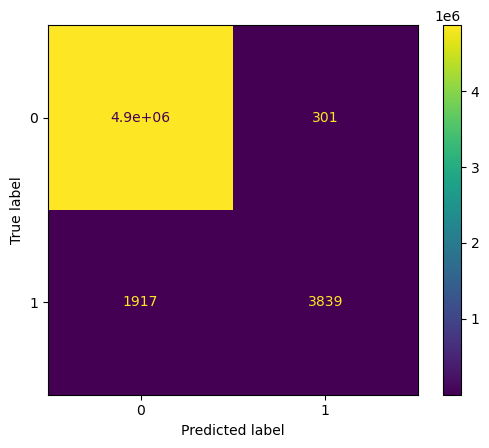

In [18]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(np.asarray(y_test).reshape(-1), np.asarray(y_pred).reshape(-1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [19]:
from sklearn.metrics import f1_score

f1_score(np.asarray(y_test).reshape(-1), np.asarray(y_pred).reshape(-1), average=None)

array([0.99977231, 0.77586904])

In [20]:
import torch.optim as optim
epochs = 4
batch_size = 10
learning_rate = 0.001

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()
train_loss_ = []
test_loss_ = []
train_acc_ = []
test_acc_ = []

In [ ]:
for epoch in range(epochs):
        optimizer = adjust_learning_rate(optimizer, epoch)

        ## training epoch
        total_acc = 0.0
        total_loss = 0.0
        total = 0.0
        for iter, traindata in enumerate(tqdm.tqdm(train_dataset)):
            # print(iter)
            train_inputs, train_labels = traindata
            train_labels = torch.squeeze(train_labels)

            if use_gpu:
                train_inputs, train_labels = Variable(train_inputs.cuda()), train_labels.cuda()
            else: troutputn_inputs = Variable(train_inputs)

            model.zero_grad()
            model.batch_size = len(train_labels)
            model.hidden = model.init_hidden()
            output = model(train_inputs.t())

            loss = loss_function(output, Variable(train_labels))
            loss.backward()
            optimizer.step()

            # calc training acc
            _, predicted = torch.max(output.data, 1)
            total_acc += (predicted == train_labels).sum()
            total += len(train_labels)
            total_loss += loss.item()

        train_loss_.append(total_loss / total)
        train_acc_.append(total_acc / total)
        ## testing epoch
        total_acc = 0.0
        total_loss = 0.0
        total = 0.0
        for iter, testdata in enumerate(tqdm.tqdm(test_dataset)):
            test_inputs, test_labels = testdata
            test_labels = torch.squeeze(test_labels)

            if use_gpu:
                test_inputs, test_labels = Variable(test_inputs.cuda()), test_labels.cuda()
            else: test_inputs = Variable(test_inputs)

            model.batch_size = len(test_labels)
            model.hidden = model.init_hidden()
            output = model(test_inputs.t())

            loss = loss_function(output, Variable(test_labels))

            # calc testing acc
            _, predicted = torch.max(output.data, 1)
            total_acc += (predicted == test_labels).sum()
            total += len(test_labels)
            total_loss += loss.item()
        test_loss_.append(total_loss / total)
        test_acc_.append(total_acc / total)

        print('[Epoch: %3d/%3d] Training Loss: %.6f, Testing Loss: %.6f, Training Acc: %.6f, Testing Acc: %.6f'
              % (epoch, epochs, train_loss_[epoch], test_loss_[epoch], train_acc_[epoch], test_acc_[epoch]))

 53%|█████▎    | 770328/1462673 [17:00<17:20, 665.28it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 13%|█▎        | 189416/1462673 [04:05<32:51, 645.98it/s]

In [ ]:
y_test = []
y_pred = []

for iter, testdata in enumerate(tqdm.tqdm(test_dataset)):
            test_inputs, test_labels = testdata
            test_labels = torch.squeeze(test_labels)

            if use_gpu:
                test_inputs, test_labels = Variable(test_inputs.cuda()), test_labels.cuda()
            else: test_inputs = Variable(test_inputs)

            model.batch_size = len(test_labels)
            model.hidden = model.init_hidden()
            output = model(test_inputs.t())
            
            _, predicted = torch.max(output.data, 1)
            
            y_pred.append(predicted.tolist())
            y_test.append(test_labels.reshape(-1).tolist())
            

In [ ]:
from sklearn.metrics import f1_score

f1_score(np.asarray(y_test).reshape(-1), np.asarray(y_pred).reshape(-1), average=None)